In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
import numpy as np
import math
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

unis    = pd.read_csv('../Education/data/hd2020.csv', encoding='cp1252')
fnames  = glob('../Education/data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
dfs     = []

for fname in tqdm(fnames): 

    year = int(fname.split('/')[-1].split('_')[0][1:])
    if year <= 2001:
        continue 

    df          = pd.read_csv(fname, index_col=0)
    df          = df.rename(columns={col: col.upper().strip() for col in df.columns})
    df          = df[df['AWLEVEL'].apply(lambda x: x in [5, 7, 9, 17, 18, 19])]
    df['year']  = year
    df['cs']    = df['CIPCODE'].apply(lambda x: (x>=11) & (x<12))
    df['cs2']   = df['CIPCODE']==11.0701
    df['mth']   = df['CIPCODE']==27.0101
    df['ugd']   = df['AWLEVEL'] == 5
    df['mst']   = df['AWLEVEL'] == 7
    df['phd']   = df['AWLEVEL'] >  7
    

    dfs.append(df)

100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


In [4]:
all_dfs                     = pd.concat(dfs)
all_dfs['white_abs']        = all_dfs[['CWHITT', 'CRACE22']].max(axis=1)
all_dfs['white_men_abs']     = all_dfs[['CWHITM', 'CRACE11']].max(axis=1)
all_dfs['white_women_abs']   = all_dfs[['CWHITW', 'CRACE12']].max(axis=1)
all_dfs['women_abs']        = all_dfs[['CTOTALW', 'CRACE16']].max(axis=1)
all_dfs['black_abs']        = all_dfs[['CBKAAT', 'CRACE18', 'DVCBKT']].max(axis=1)
all_dfs['black_men_abs']    = all_dfs[['CBKAAM', 'CRACE03', 'DVCBKM']].max(axis=1) 
all_dfs['black_women_abs']  = all_dfs[['CBKAAW', 'CRACE04', 'DVCBKW']].max(axis=1) 
all_dfs['hisp_abs']         = all_dfs[['CRACE21', 'CHISPT','DVCHST']].max(axis=1)
all_dfs['hisp_men_abs']     = all_dfs[['CRACE09', 'CHISPM','DVCHSM']].max(axis=1)
all_dfs['hisp_women_abs']   = all_dfs[['CRACE10', 'CHISPW','DVCHSW']].max(axis=1)
all_dfs['native_abs']       = all_dfs[['CAIANT', 'CRACE19']].max(axis=1)
all_dfs['total_abs']        = all_dfs[['CRACE24', 'CTOTALT']].max(axis=1)


ugds = all_dfs[all_dfs['ugd']]
# ugds.index = ugds['year']

all_cs  = ugds.groupby(['year', 'cs', 'ugd']).sum().reset_index()
all_mth = ugds.groupby(['year', 'mth', 'ugd']).sum().reset_index()




# Absolute Counts vs. Percentages

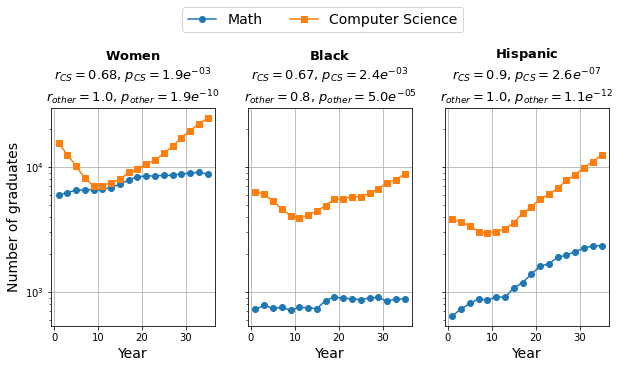

: 

In [11]:
from decimal import Decimal
from scipy.stats import pearsonr
 
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

demos = [('women', 'Women'), ('black', 'Black'), ('hisp', 'Hispanic')]

for i, (demo, title) in enumerate(demos):
    ax = axs[i]
    mth_line = all_mth[all_mth['mth']][f'{demo}_abs']
    cs_line  = all_cs[all_cs['cs']][f'{demo}_abs']
    ax.plot(mth_line, marker='o')
    ax.plot(cs_line, marker='s')

    r_other, p_other = pearsonr(mth_line, range(len(mth_line)))
    r_other, p_other = round(r_other, 1), '%.1e' % Decimal(p_other)
    p_other          = r"%se^{%s}" % (p_other.split('e')[0], p_other.split('e')[1])

    r_cs, p_cs       = pearsonr(cs_line, range(len(cs_line)))
    r_cs, p_cs       = round(r_cs, 2), '%.1e' % Decimal(p_cs)
    p_cs             = r"%se^{%s}" % (p_cs.split('e')[0], p_cs.split('e')[1])
    
    title = r"$\bf{%s}$" % title + "\n" + r"$r_{CS}=%s$" % r_cs + ", " + r"$p_{CS}=%s$" % p_cs \
                  + "\n" + r"$r_{other}=%s$" % r_other +", "+ r"$p_{other}=%s$" % p_other
    ax.set_title(title, fontsize=13)
    ax.grid()
    ax.set_yscale('log')
    ax.set_xlabel('Year', fontsize=14);

axs[0].set_ylabel('Number of graduates', fontsize=14);
axs[0].legend(['Math', 'Computer Science'], loc=[0.8, 1.35], ncol=2, fontsize=14);


# Percentage

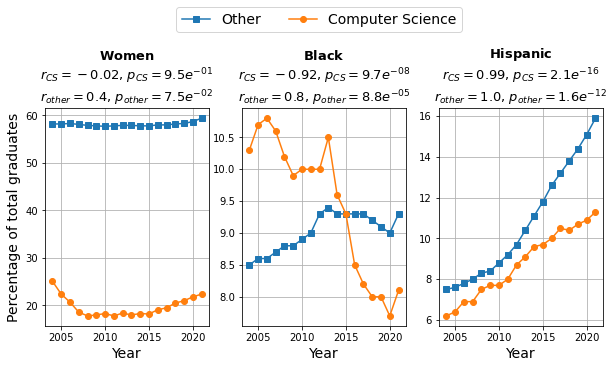

In [203]:
ugds['women_pct'] = 100*(ugds['women_abs'] / ugds['total_abs']).round(3)
ugds['black_pct'] = 100*(ugds['black_abs'] / ugds['total_abs']).round(3)
ugds['hisp_pct']  = 100*(ugds['hisp_abs']  / ugds['total_abs']).round(3)

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for i, (demo, title) in enumerate(demos):
    ax = axs[i]

    other_line = ugds[~ugds['cs']][f'{demo}_pct']
    cs_line    = ugds[ugds['cs']][f'{demo}_pct']
    ax.plot(other_line, marker='s')
    ax.plot(cs_line, marker='o')

    r_cs, p_cs       = pearsonr(cs_line, range(len(cs_line)))
    r_cs, p_cs       = round(r_cs, 2), '%.1e' % Decimal(p_cs)
    p_cs             = r"%se^{%s}" % (p_cs.split('e')[0], p_cs.split('e')[1])
    r_other, p_other = pearsonr(other_line, range(len(other_line)))
    r_other, p_other = round(r_other, 1), '%.1e' % Decimal(p_other)
    p_other          = r"%se^{%s}" % (p_other.split('e')[0], p_other.split('e')[1])

    
    title = r"$\bf{%s}$" % title + "\n" + r"$r_{CS}=%s$" % r_cs + ", " + r"$p_{CS}=%s$" % p_cs \
                  + "\n" + r"$r_{other}=%s$" % r_other +", "+ r"$p_{other}=%s$" % p_other
    ax.set_title(title, fontsize=13)
    # ax.set_title(title, fontsize=14)
    ax.grid()
    ax.set_xlabel('Year', fontsize=14);

axs[0].set_ylabel('Percentage of total graduates', fontsize=14);
axs[0].legend(['Other', 'Computer Science'], loc=[0.8, 1.35], ncol=2, fontsize=14);

# Odds Ratio

In [299]:
women_cs_odds    = ugds.drop('year', axis=1).groupby('year').apply(lambda x: x[x['cs']]['women_abs'].sum()/x['women_abs'].sum())
women_other_odds    = ugds.drop('year', axis=1).groupby('year').apply(lambda x: x[~x['cs']]['women_abs'].sum()/x['women_abs'].sum())

black_cs_odds    = ugds.drop('year', axis=1).groupby('year').apply(lambda x: x[x['cs']]['black_abs'].sum()/x['black_abs'].sum())
hisp_cs_odds     = ugds.drop('year', axis=1).groupby('year').apply(lambda x: x[x['cs']]['women_abs'].sum()/x['hisp_abs'].sum())

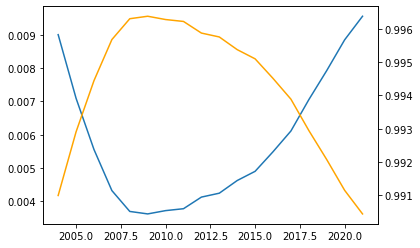

In [308]:
plt.plot(women_cs_odds)
plt.twinx()
plt.plot(women_other_odds, color='orange')
# plt.yscale('log')

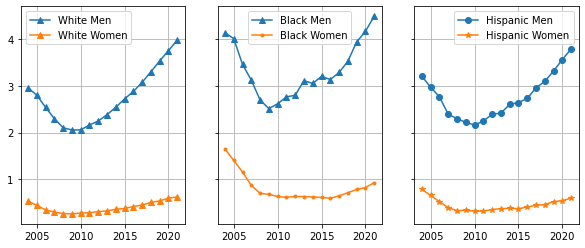

In [295]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

ww_cs_odds = ugds.drop('year', axis=1).groupby('year').apply(lambda x: x[x['cs']]['white_women_abs'].sum()/x['white_women_abs'].sum())
wm_cs_odds = ugds.drop('year', axis=1).groupby('year').apply(lambda x: x[x['cs']]['white_men_abs'].sum()/x['white_men_abs'].sum())

bm_cs_odds = ugds.drop('year', axis=1).groupby('year').apply(lambda x: x[x['cs']]['black_men_abs'].sum()/x['black_men_abs'].sum())
bw_cs_odds = ugds.drop('year', axis=1).groupby('year').apply(lambda x: x[x['cs']]['black_women_abs'].sum()/x['black_women_abs'].sum())

hm_cs_odds = ugds.drop('year', axis=1).groupby('year').apply(lambda x: x[x['cs']]['hisp_men_abs'].sum()/x['hisp_men_abs'].sum())
hw_cs_odds = ugds.drop('year', axis=1).groupby('year').apply(lambda x: x[x['cs']]['hisp_women_abs'].sum()/x['hisp_women_abs'].sum())

axs[0].plot(100*wm_cs_odds, marker='^', label='White Men')
axs[0].plot(100*ww_cs_odds, marker='^', label='White Women')
axs[0].legend()

axs[1].plot(100*bm_cs_odds, marker='^', label='Black Men')
axs[1].plot(100*bw_cs_odds, marker='.', label='Black Women')
axs[1].legend();

axs[2].plot(100*hm_cs_odds, marker='o', label='Hispanic Men')
axs[2].plot(100*hw_cs_odds, marker='*', label='Hispanic Women')
axs[2].legend();


# axs[0].set_yscale('log')
axs[0].grid()
axs[1].grid()
axs[2].grid()
# axs[0].set_yticks([1, 2, 3, 4, 5, 6])
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

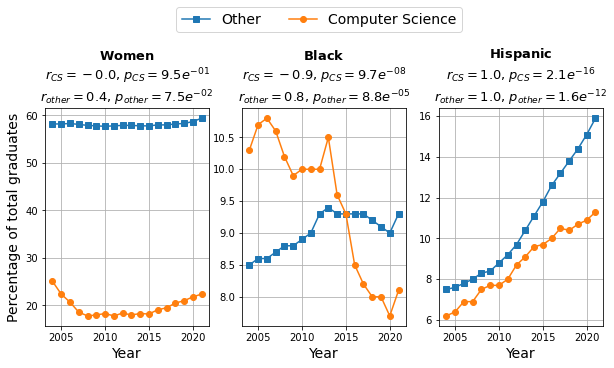

In [146]:
women_cs_odds = 100*(ugds['women_abs'] / ugds['total_abs']).round(3)
ugds['black_pct'] = 100*(ugds['black_abs'] / ugds['total_abs']).round(3)
ugds['hisp_pct']  = 100*(ugds['hisp_abs']  / ugds['total_abs']).round(3)

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for i, (demo, title) in enumerate(demos):
    ax = axs[i]

    other_line = ugds[~ugds['cs']][f'{demo}_pct']
    cs_line    = ugds[ugds['cs']][f'{demo}_pct']
    ax.plot(other_line, marker='s')
    ax.plot(cs_line, marker='o')

    r_cs, p_cs       = pearsonr(cs_line, range(len(cs_line)))
    r_cs, p_cs       = round(r_cs, 1), '%.1e' % Decimal(p_cs)
    p_cs             = r"%se^{%s}" % (p_cs.split('e')[0], p_cs.split('e')[1])
    r_other, p_other = pearsonr(other_line, range(len(other_line)))
    r_other, p_other = round(r_other, 1), '%.1e' % Decimal(p_other)
    p_other          = r"%se^{%s}" % (p_other.split('e')[0], p_other.split('e')[1])

    
    title = r"$\bf{%s}$" % title + "\n" + r"$r_{CS}=%s$" % r_cs + ", " + r"$p_{CS}=%s$" % p_cs \
                  + "\n" + r"$r_{other}=%s$" % r_other +", "+ r"$p_{other}=%s$" % p_other
    ax.set_title(title, fontsize=13)
    # ax.set_title(title, fontsize=14)
    ax.grid()
    ax.set_xlabel('Year', fontsize=14);

axs[0].set_ylabel('Percentage of total graduates', fontsize=14);
axs[0].legend(['Other', 'Computer Science'], loc=[0.8, 1.35], ncol=2, fontsize=14);

# Intersectionality

## White

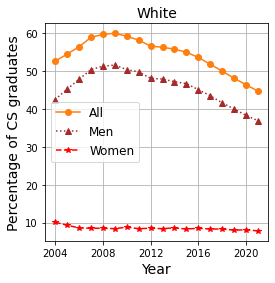

In [216]:
ugds['white_pct'] = 100*(ugds['white_abs'] / ugds['total_abs']).round(3)
ugds['white_men_pct']  = 100*(ugds['white_men_abs']  / ugds['total_abs']).round(3)
ugds['white_women_pct'] = 100*(ugds['white_women_abs'] / ugds['total_abs']).round(3)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))

demos = [('white', 'All', '#ff7f0e', '-', 'o'), ('white_men', 'Men', 'brown', ':', '^'), ('white_women', 'Women', 'red', '--', '*')]

for i, (demo, title, c, ls, m) in enumerate(demos):
    ax = axs
    # ax.plot(ugds[~ugds['cs']][f'{demo}_pct'], marker='s')
    ax.plot(ugds[ugds['cs']][f'{demo}_pct'], marker=m, label=title, linestyle=ls, color=c)
    # ax.set_title(title, fontsize=14)
    ax.grid()
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_xlabel('Year', fontsize=14);

ax.set_title('White', fontsize=14)
ax.set_ylabel('Percentage of CS graduates', fontsize=14);
ax.legend(fontsize=12);

## Black

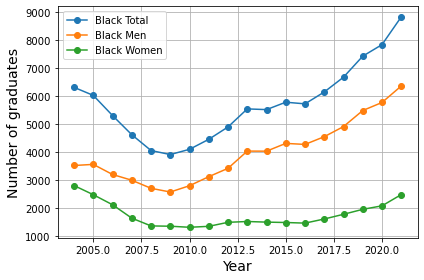

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharey=True)

demos = [('black', 'Black Total'), ('black_men', 'Black Men'), ('black_women', 'Black Women')]

for i, (demo, title) in enumerate(demos):
    ax = axs#[i]
    # ax.plot(ugds[~ugds['cs']][f'{demo}_abs'], marker='s')
    ax.plot(ugds[ugds['cs']][f'{demo}_abs'], marker='o', label=title)
    ax.grid()
    # ax.set_yscale('log')
    ax.set_xlabel('Year', fontsize=14);

ax.set_ylabel('Number of graduates', fontsize=14);
# axs[0].legend(['Non-CS', 'CS'], loc=[1, 1.1], ncol=2, fontsize=14);

ax.legend();

plt.tight_layout()

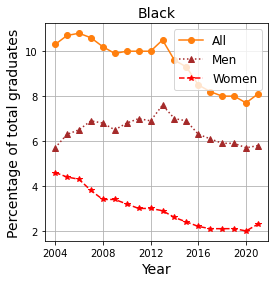

In [196]:
ugds['black_pct'] = 100*(ugds['black_abs'] / ugds['total_abs']).round(3)
ugds['black_men_pct']  = 100*(ugds['black_men_abs']  / ugds['total_abs']).round(3)
ugds['black_women_pct'] = 100*(ugds['black_women_abs'] / ugds['total_abs']).round(3)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))

demos = [('black', 'All', '#ff7f0e', '-', 'o'), ('black_men', 'Men', 'brown', ':', '^'), ('black_women', 'Women', 'red', '--', '*')]

for i, (demo, title, c, ls, m) in enumerate(demos):
    ax = axs
    # ax.plot(ugds[~ugds['cs']][f'{demo}_pct'], marker='s')
    ax.plot(ugds[ugds['cs']][f'{demo}_pct'], marker=m, label=title, linestyle=ls, color=c)
    # ax.set_title(title, fontsize=14)
    ax.grid()
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_xlabel('Year', fontsize=14);

ax.set_title('Black', fontsize=14)
ax.set_ylabel('Percentage of total graduates', fontsize=14);
ax.legend(fontsize=12);

## Hispanic

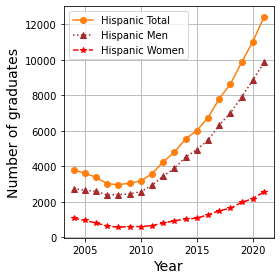

In [152]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4), sharey=True)

demos = [('hisp', 'Hispanic Total','#ff7f0e', '-', 'o'), ('hisp_men', 'Hispanic Men', 'brown', ':', '^'), ('hisp_women', 'Hispanic Women', 'red', '--', '*')]

for i, (demo, title, c, ls, m) in enumerate(demos):
    ax = axs
    ax.plot(ugds[ugds['cs']][f'{demo}_abs'], marker=m, label=title, linestyle=ls, color=c)
    ax.grid()
    ax.set_xlabel('Year', fontsize=14);

ax.set_ylabel('Number of graduates', fontsize=14);
ax.legend();
plt.tight_layout()

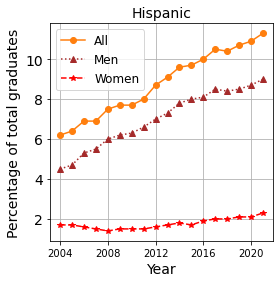

In [197]:
ugds['hisp_pct'] = 100*(ugds['hisp_abs'] / ugds['total_abs']).round(3)
ugds['hisp_men_pct']  = 100*(ugds['hisp_men_abs']  / ugds['total_abs']).round(3)
ugds['hisp_women_pct'] = 100*(ugds['hisp_women_abs'] / ugds['total_abs']).round(3)


fig, axs = plt.subplots(1, 1, figsize=(4, 4))

demos = [('hisp', 'All','#ff7f0e', '-', 'o'), ('hisp_men', 'Men', 'brown', ':', '^'), ('hisp_women', 'Women', 'red', '--', '*')]

for i, (demo, title, c, ls, m) in enumerate(demos):
    ax = axs
    # ax.plot(ugds[~ugds['cs']][f'{demo}_pct'], marker='s')
    ax.plot(ugds[ugds['cs']][f'{demo}_pct'], marker=m, label=title, linestyle=ls, color=c)
    # ax.set_title(title, fontsize=14)
    ax.grid()
    ax.set_xlabel('Year', fontsize=14);
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))

ax.set_title('Hispanic', fontsize=14)

ax.set_ylabel('Percentage of total graduates', fontsize=14);
ax.legend(fontsize=12);

plt.yticks(fontsize=14);

## All

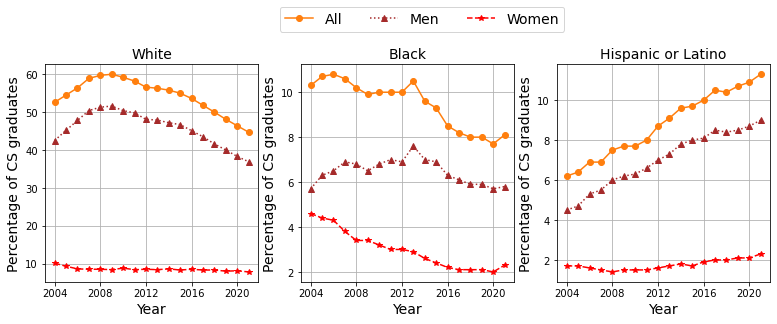

In [262]:
ugds['white_pct']       = 100*(ugds['white_abs']        / ugds['total_abs']).round(3)
ugds['white_men_pct']   = 100*(ugds['white_men_abs']     / ugds['total_abs']).round(3)
ugds['white_women_pct'] = 100*(ugds['white_women_abs']   / ugds['total_abs']).round(3)

ugds['hisp_pct']        = 100*(ugds['hisp_abs']         / ugds['total_abs']).round(3)
ugds['hisp_men_pct']    = 100*(ugds['hisp_men_abs']     / ugds['total_abs']).round(3)
ugds['hisp_women_pct']  = 100*(ugds['hisp_women_abs']   / ugds['total_abs']).round(3)

ugds['black_pct']       = 100*(ugds['black_abs']        / ugds['total_abs']).round(3)
ugds['black_men_pct']   = 100*(ugds['black_men_abs']    / ugds['total_abs']).round(3)
ugds['black_women_pct'] = 100*(ugds['black_women_abs']  / ugds['total_abs']).round(3)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

demos = [('', 'All', '#ff7f0e', '-', 'o'), ('_men', 'Men', 'brown', ':', '^'), ('_women', 'Women', 'red', '--', '*')]

race_map = {'white': "White", 'hisp': "Hispanic or Latino", 'black': "Black"}
for i, race in enumerate(['white', 'black', 'hisp']): 
    ax = axs[i]
    for j, (gender, title, c, ls, m) in enumerate(demos):
        demo = race + gender
        ax.plot(ugds[ugds['cs']][f'{demo}_pct'], marker=m, label=title, linestyle=ls, color=c)
        # ax.set_title(title, fontsize=14)
        ax.grid()
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.set_xlabel('Year', fontsize=14);
        # ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    ax.set_title(race_map[race], fontsize=14)

    ax.set_ylabel('Percentage of CS graduates', fontsize=14);

axs[0].legend(ncol=3, loc=(1.1, 1.15), fontsize=14);

# plt.tight_layout()

In [266]:
ugds['white_pct']       = 100*(ugds['white_abs']        / ugds['total_abs']).round(3)
ugds['white_men_pct']   = 100*(ugds['white_men_abs']     / ugds['total_abs']).round(3)
ugds['white_women_pct'] = 100*(ugds['white_women_abs']   / ugds['total_abs']).round(3)

ugds['hisp_pct']        = 100*(ugds['hisp_abs']         / ugds['total_abs']).round(3)
ugds['hisp_men_pct']    = 100*(ugds['hisp_men_abs']     / ugds['total_abs']).round(3)
ugds['hisp_women_pct']  = 100*(ugds['hisp_women_abs']   / ugds['total_abs']).round(3)

ugds['black_pct']       = 100*(ugds['black_abs']        / ugds['total_abs']).round(3)
ugds['black_men_pct']   = 100*(ugds['black_men_abs']    / ugds['total_abs']).round(3)
ugds['black_women_pct'] = 100*(ugds['black_women_abs']  / ugds['total_abs']).round(3)

for col in ['white_pct', 'white_men_pct', 'white_women_pct', 'black_pct', 'black_men_pct', 'black_women_pct', 'hisp_pct', 'hisp_men_pct', 'hisp_women_pct']: 
    r, pval = pearsonr(ugds[ugds['cs']][col], range(len(ugds[ugds['cs']])))
    print(col, "\t", round(r, 2), '%.1e' % Decimal(pval))

white_pct 	 -0.73 6.5e-04
white_men_pct 	 -0.66 2.8e-03
white_women_pct 	 -0.76 2.2e-04
black_pct 	 -0.92 9.7e-08
black_men_pct 	 -0.33 1.8e-01
black_women_pct 	 -0.96 4.8e-10
hisp_pct 	 0.99 2.1e-16
hisp_men_pct 	 0.99 2.3e-14
hisp_women_pct 	 0.82 2.8e-05


# Institution

In [25]:
all_dfs[all_dfs['cs']].reset_index().groupby('UNITID').size()

UNITID
100654     36
100663     75
100690      7
100706    103
100724     44
         ... 
493895      3
494269      3
495767     29
496706      1
497037      1
Length: 2251, dtype: int64

In [26]:
all_dfs['women_pct'] = 100*(all_dfs['women_abs'] / all_dfs['total_abs']).round(3)
all_dfs['black_pct'] = 100*(all_dfs['black_abs'] / all_dfs['total_abs']).round(3)
all_dfs['hisp_pct']  = 100*(all_dfs['hisp_abs']  / all_dfs['total_abs']).round(3)

In [27]:
inst_stats = all_dfs.groupby(['year', 'cs']).apply(lambda x: pd.Series({'mean':x['black_pct'].mean(), 'sem': x['black_pct'].sem()})).reset_index()

(0.5151611730677821, 0.028677116801153823)

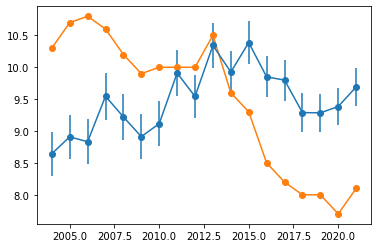

In [28]:
a = inst_stats[inst_stats['cs']]
plt.errorbar(a['year'], a['mean'], yerr=a['sem'], marker='o')
plt.plot(ugds[ugds['cs']]['black_pct'], marker='o')

pearsonr(range(len(a)), a['mean'])


# Stats

In [29]:
cs   = all_dfs[all_dfs['cs']]
cs_unis = cs.reset_index().groupby(['UNITID', 'year']).sum()

cs_unis['women_pct']       = 100*(cs_unis['women_abs'] / cs_unis['total_abs']).round(3)
cs_unis['black_pct']       = 100*(cs_unis['black_abs'] / cs_unis['total_abs']).round(3)
cs_unis['hispanic_pct']    = 100*(cs_unis['hisp_abs'] / cs_unis['total_abs']).round(3)

from scipy.stats import pearsonr, spearmanr

filtered = cs_unis[cs_unis['women_pct'].notna()]
filtered = filtered.reset_index()

corr_func = spearmanr#pearsonr

women_r     = filtered.groupby('UNITID').apply(lambda x: corr_func(x['year'], x['women_pct'])[0] if len(x) > 2 else 0)
black_r     = filtered.groupby('UNITID').apply(lambda x: corr_func(x['year'], x['black_pct'])[0] if len(x) > 2 else 0)
hispanic_r  = filtered.groupby('UNITID').apply(lambda x: corr_func(x['year'], x['hispanic_pct'])[0] if len(x) > 2 else 0)

women_pval      = filtered.groupby('UNITID').apply(lambda x: corr_func(x['year'], x['women_pct'])[1] if len(x) > 2 else 1)
black_pval      = filtered.groupby('UNITID').apply(lambda x: corr_func(x['year'], x['black_pct'])[1] if len(x) > 2 else 1)
hispanic_pval   = filtered.groupby('UNITID').apply(lambda x: corr_func(x['year'], x['hispanic_pct'])[1] if len(x) > 2 else 1)

In [13]:
black_r.mean()

0.090069998460262

## Basic Stats

77 % of unis have non-significant trends

In [325]:
100 * sum(women_pval > 0.01) / len(women_pval)

77.19101123595506

UNITID
100724    0.520953
100830    0.188120
100858    1.000000
100937    0.007148
101189    0.811038
            ...   
486840    0.093750
486901    0.799525
487296    0.396501
490805    1.000000
495767    1.000000
Length: 890, dtype: float64

In [30]:
stats = {}

dfs = {}

for demo_r, demo_pval, demo_name in [(women_r, women_pval, "women"), (black_r, black_pval, "black"), (hispanic_r, hispanic_pval, "hispanic")]:

    demo_pval = demo_pval.fillna(1)
    demo_pos = demo_r[(demo_pval < 0.05)  & (demo_r > 0)]
    demo_neg = demo_r[(demo_pval < 0.05)  & (demo_r < 0)]
    demo_s   = demo_r[(demo_pval < 0.05)  & (demo_r == 0)]
    demo_ns  = demo_r[(demo_pval >= 0.05)]

    dfs['%s_pos' % demo_name] = demo_pos
    dfs['%s_neg' % demo_name] = demo_neg
    dfs['%s_s' % demo_name]   = demo_s
    dfs['%s_ns' % demo_name]  = demo_ns

    stats[demo_name] = [round(len(demo_pos)/len(demo_r), 2),\
                        round(len(demo_neg)/len(demo_r), 2),\
                        round(len(demo_s)/len(demo_r), 2),\
                        round(len(demo_ns)/len(demo_r), 2),\
                        len(demo_r)]

In [31]:
stats = pd.DataFrame(stats)
stats.index = ['pos', 'neg', 's', 'ns', 'N']
stats.transpose()

,pos,neg,s,ns,N
women,0.11,0.07,0.0,0.82,2132.0
black,0.12,0.05,0.0,0.83,2132.0
hispanic,0.23,0.01,0.0,0.76,2132.0


(-0.6932545204253635, 0.6619240216777882, 0.06306799017190402)

In [44]:

black_neg = black_r[(black_pval < 0.01)  & (black_r < 0)]
black_pos = black_r[(black_pval < 0.01)  & (black_r > 0)]
ns        = black_r[(black_pval >= 0.01)]

ns_data  = all_dfs.loc[ns.index]
ns_data  = ns_data[ns_data['ugd']]

ns_data['women_pct'] = 100*(ns_data['women_abs'] / ns_data['total_abs']).round(3)
ns_data['black_pct'] = 100*(ns_data['black_abs'] / ns_data['total_abs']).round(3)
ns_data['hisp_pct']  = 100*(ns_data['hisp_abs']  / ns_data['total_abs']).round(3)

ns_data = ns_data.groupby(['year', 'cs', 'ugd']).apply(lambda x: pd.Series({'mean': x['black_pct'].mean(), 'std': x['black_pct'].sem()})).reset_index()
ns_data = ns_data[ns_data['cs']]


neg_data = all_dfs.loc[black_neg.index]
neg_data = neg_data[neg_data['ugd']]

neg_data['women_pct'] = 100*(neg_data['women_abs'] / neg_data['total_abs']).round(3)
neg_data['black_pct'] = 100*(neg_data['black_abs'] / neg_data['total_abs']).round(3)
neg_data['hisp_pct']  = 100*(neg_data['hisp_abs']  / neg_data['total_abs']).round(3)

neg_data = neg_data.groupby(['year', 'cs', 'ugd']).apply(lambda x: pd.Series({'mean': x['black_pct'].mean(), 'std': x['black_pct'].sem()})).reset_index()
neg_data = neg_data[neg_data['cs']]

pos_data = all_dfs.loc[black_pos.index]
# pos_data = pos_data.groupby(['year', 'cs', 'ugd']).sum().reset_index()
pos_data = pos_data[pos_data['ugd']]

pos_data['women_pct'] = 100*(pos_data['women_abs'] / pos_data['total_abs']).round(3)
pos_data['black_pct'] = 100*(pos_data['black_abs'] / pos_data['total_abs']).round(3)
pos_data['hisp_pct']  = 100*(pos_data['hisp_abs']  / pos_data['total_abs']).round(3)

pos_data = pos_data.groupby(['year', 'cs', 'ugd']).apply(lambda x: pd.Series({'mean': x['black_pct'].mean(), 'std': x['black_pct'].sem()})).reset_index()
pos_data = pos_data[pos_data['cs']]
# plt.errorbar(pos_data[pos_data['cs']]['black_pct'], marker='s')



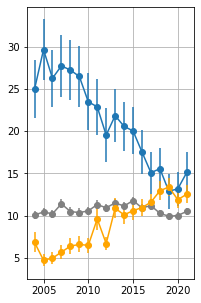

In [45]:
plt.figure(figsize=(3, 5))

plt.errorbar(x=neg_data['year'], y=neg_data['mean'],  yerr = neg_data['std'], marker='o')
plt.errorbar(x=ns_data['year'], y=ns_data['mean'],  yerr = ns_data['std'], marker='o', color='gray')
plt.errorbar(x=pos_data['year'], y=pos_data['mean'],  yerr = pos_data['std'], marker='o', color='orange')

plt.grid()

(array([1., 1., 3., 3., 1., 2., 6., 0., 0., 1.]),
 array([29.65714286, 31.97672269, 34.29630252, 36.61588235, 38.93546218,
        41.25504202, 43.57462185, 45.89420168, 48.21378151, 50.53336134,
        52.85294118]),
 <BarContainer object of 10 artists>)

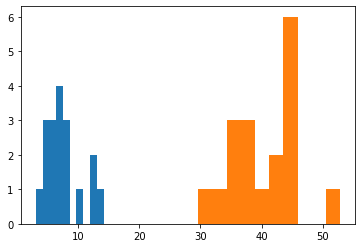

In [439]:
plt.hist(pos_data['mean'])
plt.hist(neg_data['mean'])
# neg_data.hist('mean')

In [337]:
unis = unis.set_index('UNITID')


5    8
2    3
3    2
8    1
7    1
Name: OBEREG, dtype: int64

In [397]:
black_neg_unis = unis.loc[black_neg.index]
black_pos_unis = unis.loc[black_pos.index]

stats = pd.concat([black_neg_unis['OBEREG'].value_counts(), black_pos_unis['OBEREG'].value_counts()], axis=1)
stats.columns = ['Negative', 'Positive']
(100*stats.sort_index() / stats.sum()).fillna(0).round(0)

,Negative,Positive
1,0.0,19.0
2,20.0,16.0
3,13.0,10.0
4,0.0,10.0
5,53.0,32.0
7,7.0,6.0
8,7.0,6.0


In [430]:
black_neg_unis = unis.loc[black_neg.index]
black_pos_unis = unis.loc[black_pos.index]

stats = pd.concat([black_neg_unis['STABBR'].value_counts(), black_pos_unis['STABBR'].value_counts()], axis=1)
stats.columns = ['Negative', 'Positive']
(100*stats.sort_index() / stats.sum()).fillna(0).round(0).sort_values('Negative')

,Negative,Positive
WV,0.0,3.0
CO,0.0,3.0
FL,0.0,3.0
IA,0.0,3.0
PA,0.0,6.0
IN,0.0,6.0
LA,0.0,6.0
MA,0.0,10.0
VT,0.0,6.0
ME,0.0,3.0


In [375]:
black_neg_unis = unis.loc[black_neg.index]
black_pos_unis = unis.loc[black_pos.index]

stats = pd.concat([black_neg_unis['SECTOR'].value_counts(), black_pos_unis['SECTOR'].value_counts()], axis=1)
stats.columns = ['Negative', 'Positive']
(100*stats.sort_index() / stats.sum()).round(0)

,Negative,Positive
1,80.0,45.0
2,20.0,48.0
3,NaN,6.0


In [374]:
black_neg_unis = unis.loc[black_neg.index]
black_pos_unis = unis.loc[black_pos.index]

stats = pd.concat([black_neg_unis['INSTSIZE'].value_counts(), black_pos_unis['INSTSIZE'].value_counts()], axis=1)
stats.columns = ['Negative', 'Positive']
(100*stats.sort_index() / stats.sum()).round(0)

,Negative,Positive
1,NaN,10.0
2,33.0,32.0
3,20.0,19.0
4,13.0,29.0
5,33.0,10.0


In [419]:
a = black_neg_unis.groupby(['INSTSIZE', 'OBEREG']).size() 
(100* a / a.sum()).round(0).astype(int).sort_values()#['OBEREG', 'INSTSIZE'])

INSTSIZE  OBEREG
2         2          7
          3          7
3         3          7
4         2          7
          5          7
5         2          7
          7          7
          8          7
3         5         13
5         5         13
2         5         20
dtype: int64

In [416]:
a = black_pos_unis.groupby(['INSTSIZE', 'OBEREG']).size() 
(100 * a / a.sum()).round(0).astype(int).sort_values().reset_index()

,INSTSIZE,OBEREG,0
0,3,4,3
1,4,8,3
2,4,4,3
3,4,2,3
4,2,4,3
5,3,8,3
6,3,2,3
7,3,3,3
8,5,2,3
9,5,7,6


In [399]:
black_neg_unis = unis.loc[black_neg.index]
black_pos_unis = unis.loc[black_pos.index]

stats = pd.concat([black_neg_unis['CARNEGIE'].value_counts(), black_pos_unis['CARNEGIE'].value_counts()], axis=1)
stats.columns = ['Negative', 'Positive']
(100*stats.sort_index() / stats.sum()).fillna(0).round(0).astype(int)

,Negative,Positive
-2,7,3
15,27,10
16,7,13
21,47,39
22,0,10
31,7,16
32,7,6
33,0,3


In [432]:
black_neg_unis = unis.loc[black_neg.index]
black_pos_unis = unis.loc[black_pos.index]

stats = pd.concat([black_neg_unis['HBCU'].value_counts(), black_pos_unis['HBCU'].value_counts()], axis=1)
stats.columns = ['Negative', 'Positive']
(100*stats.sort_index() / stats.sum()).fillna(0).round(0).astype(int)

,Negative,Positive
1,47,6
2,53,94


In [431]:
black_neg_unis['INSTNM'].sort_values()

UNITID
190567                              CUNY City College
144005                       Chicago State University
162283                        Coppin State University
198507                Elizabeth City State University
131469                   George Washington University
139755    Georgia Institute of Technology-Main Campus
199102          North Carolina A & T State University
199157              North Carolina Central University
199193     North Carolina State University at Raleigh
147776               Northeastern Illinois University
102298                              Talladega College
221838                     Tennessee State University
110671             University of California-Riverside
234155                      Virginia State University
433387                   Western Governors University
Name: INSTNM, dtype: object

In [424]:
unis.loc[black_pos_unis['INSTNM'].index][['INSTNM', 'CONTROL', 'SECTOR']]

,INSTNM,CONTROL,SECTOR
UNITID,,,
110486,California State University-Bakersfield,1,1
122436,University of San Diego,2,2
126827,Colorado Technical University-Colorado Springs,3,3
138309,Rasmussen University-Florida,3,3
139311,Clayton State University,1,1
151379,Indiana University-Southeast,1,1
152600,Valparaiso University,2,2
153861,Maharishi International University,2,2
160630,Southern University at New Orleans,1,1


In [426]:
unis.loc[black_neg_unis['INSTNM'].index][['INSTNM', 'CONTROL', 'SECTOR', 'OBEREG']].sort_values('OBEREG')

,INSTNM,CONTROL,SECTOR,OBEREG
UNITID,,,,
131469,George Washington University,2,2,2
162283,Coppin State University,1,1,2
190567,CUNY City College,1,1,2
144005,Chicago State University,1,1,3
147776,Northeastern Illinois University,1,1,3
102298,Talladega College,2,2,5
139755,Georgia Institute of Technology-Main Campus,1,1,5
198507,Elizabeth City State University,1,1,5
199102,North Carolina A & T State University,1,1,5


(20.0, 50.0)

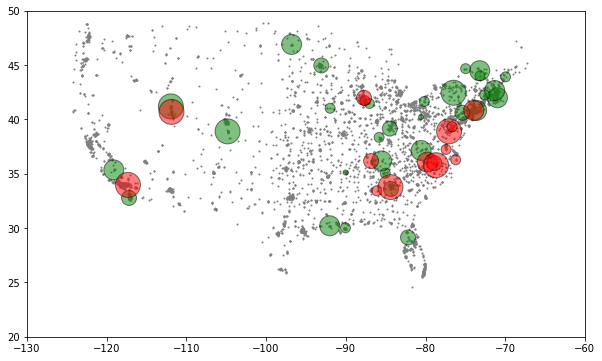

In [400]:
plt.figure(figsize=(10, 6))
plt.scatter(unis['LONGITUD'], unis['LATITUDE'], color='gray', s=1)
plt.scatter(black_pos_unis['LONGITUD'], black_pos_unis['LATITUDE'], color='green', s=(5*black_pos_unis['INSTSIZE'])**2, linewidths=1, edgecolors='black', alpha=0.5)
plt.scatter(black_neg_unis['LONGITUD'], black_neg_unis['LATITUDE'], color='red', s=(5*black_neg_unis['INSTSIZE'])**2, linewidths=1, edgecolors='black', alpha=0.5)
plt.xlim(-130, -60)
plt.ylim(20, 50)

In [341]:
black_pval = black_pval.reset_index().rename(columns={0: 'pval'})
merged = pd.merge(unis, black_pval, left_on='UNITID', right_on='UNITID')

(20.0, 50.0)

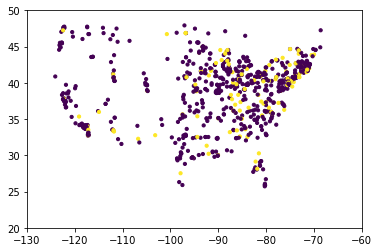

In [349]:
plt.scatter(merged['LONGITUD'], merged['LATITUDE'], c=merged['pval'] < 0.01, s=10)
plt.xlim(-130, -60)
plt.ylim(20, 50)

<AxesSubplot:xlabel='neg', ylabel='total_abs'>

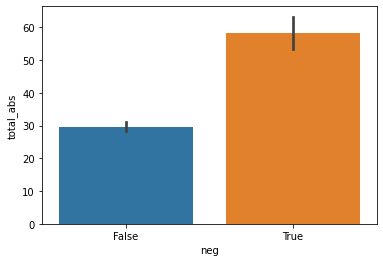

In [261]:
neg_vals = all_dfs.loc[black_neg.index, ['total_abs']]
neg_vals['neg'] = True 

pos_vals = all_dfs.loc[black_pos.index, ['total_abs']]
pos_vals['neg'] = False

vals = pd.concat([neg_vals, pos_vals])

# sns.boxplot(x='neg', y='total_abs', data=vals, showfliers=False)
sns.barplot(x='neg', y='total_abs', data=vals)
# plt.yscale('log')


In [214]:
hisp_pos = hispanic_delta[(hispanic_pval < 0.01) & (hispanic_delta > 0)]
hisp_neg = hispanic_delta[(hispanic_pval < 0.01) & (hispanic_delta < 0)]

hisp_pos.shape, hisp_neg.shape

((115,), (2,))

In [190]:
deltas = pd.concat([(women_delta >= 0).value_counts(), (black_delta >= 0).value_counts(), (hispanic_delta >= 0).value_counts()], axis=1)
deltas.columns = ['women', 'black', 'hispanic']
deltas.index = ['positive', 'negative']
deltas = (deltas/deltas.sum(axis=0)).round(2)
deltas

,women,black,hispanic
positive,0.66,0.57,0.73
negative,0.34,0.43,0.27


In [191]:
black_pos = black_delta[black_delta>0]
black_neg = black_delta[black_delta<0]

pos = all_dfs.loc[black_pos.index]
neg = all_dfs.loc[black_neg.index]

In [192]:
pos['ugd'].value_counts()

True     556092
False    290336
Name: ugd, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd4e870bc40>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd4e8705220>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd4e870b970>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd4e87057c0>],
 'fliers': [],
 'means': []}

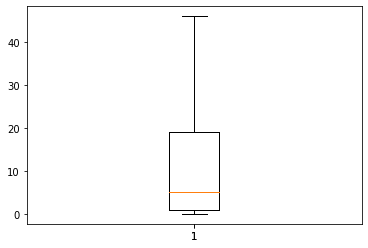

In [188]:
plt.boxplot(pos[pos['ugd']]['total_abs'], showfliers=False)
plt.boxplot(neg[neg['ugd']]['total_abs'], showfliers=False)

# sns.boxplot(x='ugd', y='total_abs', data=all_dfs)   

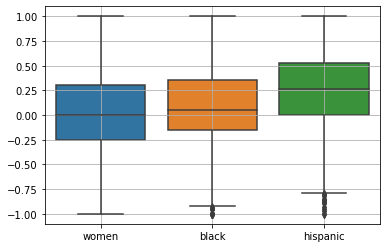

In [124]:
import seaborn as sns 

sns.boxplot(data=deltas)
plt.grid()

In [101]:
deltas = pd.concat([women_delta, black_delta, hispanic_delta], axis=1)
deltas.columns = ['women', 'black', 'hispanic']
# 100*(deltas > 0).sum() / len(deltas)

deltas.mean()

women       0.024186
black       0.082038
hispanic    0.240416
dtype: float64

In [58]:
x = filtered[filtered['UNITID']==100654]
x = x.sort_values('year')

In [60]:
x['women_pct'].values[0] - x['women_pct'].values[-1]

8.100000000000001

In [49]:
filtered['women_pct'].values[0] - filtered['women_pct'].values[-1]

24.7

In [36]:
unis

,,CIPCODE,MAJORNUM,AWLEVEL,CNRALM,CNRALW,CRACE03,CRACE04,CRACE05,CRACE06,CRACE07,...,whitemen_abs,women_abs,black_abs,hisp_abs,native_abs,total_abs,women_pct,black_pct,hispanic_pct,women_delta
UNITID,year,,,,,,,,,,,,,,,,,,,,,
